# 案例：用随机森林回归填补缺失值
## 目录
1. 制作有缺失值的数据
2. 填补缺失值
        * 0
        * 均值
        * 随机森林
            * 初始补0
            * 初始补均值
3. 用填补好的数据建模
4. 用所得的结果画条形图

## 制作有缺失值的数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

In [2]:
boston = load_boston()
X_full = boston.data
y_full = boston.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

In [3]:
missing_rate=0.5
n_missing_samples = int(n_samples*n_features*missing_rate)

In [4]:
rng = np.random.RandomState(0)
missing_index = rng.permutation(n_features*n_samples)[:n_missing_samples]

In [5]:
X_missing = X_full.copy()
y_missing = y_full.copy()

In [6]:
X_missing_flatten = X_missing.flatten()
X_missing_flatten[missing_index]=np.nan
X_missing = X_missing_flatten.reshape(X_full.shape)

检验下是否有50%的数据为缺失值

In [7]:
np.isnan(X_missing).sum() == n_missing_samples

True

## 填补缺失值
分别采用三个策略来填补缺失值
1. 0
2. 均值
3. 随机森林

其中前两个策略直接使用sklearn.impute.SimpleImputer就可以简单实现  
区别在于
strategy="constant",full_value=0  
strategy="mean"  
strategy="median"  
strategy="most_frequent"

### 使用0来填补缺失值
使用sklearn.impute 中的SimpleImputer  
SimpleImputer(missing_value=np.nan.strategy="constant",full_value=0)#当然也可以填你喜欢的数字

In [8]:
from sklearn.impute import SimpleImputer
imp_0 = SimpleImputer(missing_values=np.nan,strategy="constant",fill_value=0)
X_missing_0 = imp_0.fit_transform(X_missing)

### 使用均值来进行填补
SimpleImputer中的strategy="mean"

In [9]:
imp_mean = SimpleImputer(missing_values=np.nan,strategy="mean")
X_missing_mean = imp_mean.fit_transform(X_missing)

### 使用随机森林填补缺失值

遍历所有特征，从缺失最少的开始填补  
填补一个特征时，先将其他特征的缺失值用0代替  
每完成一次回归预测，就将预测值放在原本的特征矩阵中，补下一个特征。  
每一次填补完毕，有缺失值的特征会减少一个，  
所以每次循环后，需要用0填补的特征越来越少。  
当进行到最后一个特征时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特征需要用0来进行填补。而我们已经使用回归为其他特征填补了大量有效信息，可以用来填补缺失最多的特征。  
遍历所有特征后，数据就完整，不再有缺失值了。

In [10]:
X_missing_r0 = X_missing.copy()

In [11]:
from sklearn.ensemble import RandomForestRegressor
countnan = np.sum(np.isnan(X_missing_r0),axis=0)
colindex = np.argsort(countnan)
for col in colindex:
    
    df = pd.DataFrame(X_missing_r0)
    fillc = df.iloc[:,col]
    df = pd.concat([df.iloc[:,df.columns != col],pd.DataFrame(y_full)],axis=1)
    df_0 = SimpleImputer(missing_values=np.nan,strategy="constant",fill_value = 0).fit_transform(df)
    
    y_train = fillc[fillc.notnull()]
    y_test = fillc[fillc.isnull()]
    X_train = df_0[y_train.index,:]
    X_test = df_0[y_test.index,:]
    
    #用随机森林回归来填补缺失值
    rfc = RandomForestRegressor(n_estimators=50)
    rfc.fit(X_train,y_train)
    y_predict = rfc.predict(X_test)
    
    #将填补好的特征返回到原始的特征矩阵中
    X_missing_r0[np.isnan(X_missing_r0[:,col]),col]=y_predict
    print(np.isnan(X_missing_r0).sum(axis=0))

[251 257 263 241 255 255 247 259 249 264 256 254   0]
[251 257 263   0 255 255 247 259 249 264 256 254   0]
[251 257 263   0 255 255   0 259 249 264 256 254   0]
[251 257 263   0 255 255   0 259   0 264 256 254   0]
[  0 257 263   0 255 255   0 259   0 264 256 254   0]
[  0 257 263   0 255 255   0 259   0 264 256   0   0]
[  0 257 263   0   0 255   0 259   0 264 256   0   0]
[  0 257 263   0   0   0   0 259   0 264 256   0   0]
[  0 257 263   0   0   0   0 259   0 264   0   0   0]
[  0   0 263   0   0   0   0 259   0 264   0   0   0]
[  0   0 263   0   0   0   0   0   0 264   0   0   0]
[  0   0   0   0   0   0   0   0   0 264   0   0   0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
X_missing_rmean = X_missing.copy()

In [13]:
countnan = np.isnan(X_missing_rmean).sum(axis=0)
indexcol = np.argsort(countnan)
for col in indexcol:
    
    temp = X_missing_rmean.copy()
    y = temp[:,col]
    X = np.hstack([temp[:,np.arange(X_missing.shape[1])!=col],y_full[:,np.newaxis]])
    indexnan = np.isnan(y)
    
    X = SimpleImputer(missing_values=np.nan,strategy="mean").fit_transform(X)
    
    X_train = X[~indexnan,:]
    X_test = X[indexnan,:]
    y_train = y[~indexnan]
    
    
    reg = RandomForestRegressor(n_estimators=100)
    reg.fit(X_train,y_train)
    pre = reg.predict(X_test)
    X_missing_rmean[indexnan,col]=pre
    print(np.isnan(X_missing_rmean).sum(axis=0))

[251 257 263 241 255 255 247 259 249 264 256 254   0]
[251 257 263   0 255 255 247 259 249 264 256 254   0]
[251 257 263   0 255 255   0 259 249 264 256 254   0]
[251 257 263   0 255 255   0 259   0 264 256 254   0]
[  0 257 263   0 255 255   0 259   0 264 256 254   0]
[  0 257 263   0 255 255   0 259   0 264 256   0   0]
[  0 257 263   0   0 255   0 259   0 264 256   0   0]
[  0 257 263   0   0   0   0 259   0 264 256   0   0]
[  0 257 263   0   0   0   0 259   0 264   0   0   0]
[  0   0 263   0   0   0   0 259   0 264   0   0   0]
[  0   0 263   0   0   0   0   0   0 264   0   0   0]
[  0   0   0   0   0   0   0   0   0 264   0   0   0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]


## 对填补好的数据进行建模

In [25]:
from sklearn.model_selection import cross_val_score
X = [X_full,X_missing_0,X_missing_mean,X_missing_r0,X_missing_rmean]

mse = []
std = []
for x in X:
    estimator = RandomForestRegressor(random_state=666,n_estimators=100)
    scores = cross_val_score(estimator,x,y_full,scoring="neg_mean_squared_error",cv=5).mean()
    mse.append(scores*-1)

## 用所得的结果画出条形图

采用mse作为评价指标

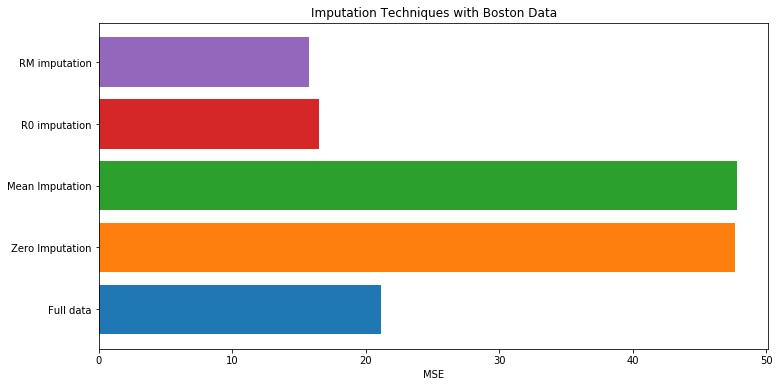

In [26]:
x_labels = ["Full data","Zero Imputation","Mean Imputation","R0 imputation","RM imputation"]
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
for i in np.arange(len(mse)):
    ax.barh(i,mse[i])
ax.set_title("Imputation Techniques with Boston Data")
ax.set_xlabel("MSE")
ax.set_yticks(np.arange(len(mse)))
ax.set_yticklabels(x_labels)
plt.show()

采用r2作为评价指标

In [27]:
from sklearn.model_selection import cross_val_score
X = [X_full,X_missing_0,X_missing_mean,X_missing_r0,X_missing_rmean]

r2 = []
for x in X:
    estimator = RandomForestRegressor(random_state=666,n_estimators=100)
    scores = cross_val_score(estimator,x,y_full,cv=5).mean()
    r2.append(scores)

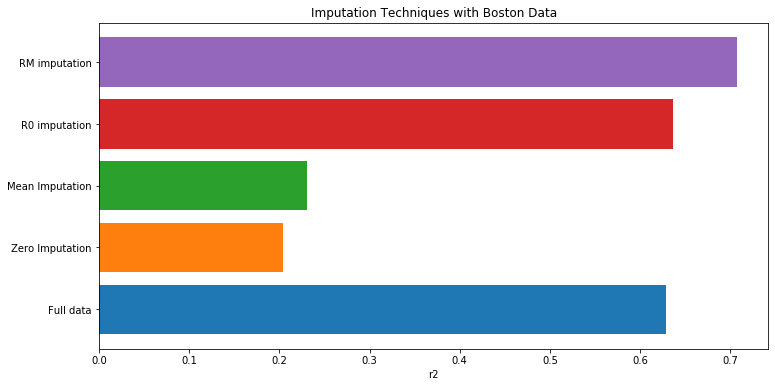

In [28]:
x_labels = ["Full data","Zero Imputation","Mean Imputation","R0 imputation","RM imputation"]
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
for i in np.arange(len(r2)):
    ax.barh(i,r2[i])
ax.set_title("Imputation Techniques with Boston Data")
ax.set_xlabel("r2")
ax.set_yticks(np.arange(len(r2)))
ax.set_yticklabels(x_labels)
plt.show()

可以看出用随机森林填补缺失值的效果很赞！